# Estimating and Drawing Distributions over Trees

In this notebook I am hoping to delineate how one might recover distributions over all resolutions of a tree, and all possible parameter values of a tree, given:

1. Prior information on splits 
2. Dates of moribundity
2. Locations and paths through locations
3. Transitions among Dogolpolsky classes

As it happens, we have a series of class methods - and in one case a stand-alone method which takes a parameterized tree as an argument - to calculate likelihood. While I have rolled this likelihood into `PyIETools`, an example of it appears here, which shows how the likelihood is calculated over trees. 

In the future, it might be desirable to rewrite the class methods as stand-alone functions. This is because one can more easily compile code written in this way using the `Numba` package. Ultimately, one might then be able to turn off the Python Global Interpreter Lock (GIL) so the four components of likelihood can be computed at the same time. 

A big part of this is experimental - fumbling around until a reliable method for estimating trees can be found. In the end, I am hoping to implement estimation across a bunch of linguistic stocks in parallel, we will hopefully have some stylistic improvements to offer. 

## Likelihood given parameters, tree structure

Suppose we have decided on a resolution of our tree into a bifurcating tree so that all splits between groups are pairwise. Given this, we can calculate the likelihood of the tree using something like the following `mlfun_ex` function (Once again after the usual job of importing all of our modules)



In [1]:
# My modules

import PyIEClasses
import PyIETools

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import copy

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
def mlfun_ex(x, Obj):
    '''Take a language tree object, set the parameters, unpack them
       and then calculate the entire likelihood'''

    Obj.parameters = np.matrix(x)
    Obj.unpack()
    Obj.settimes()
    L1=-Obj.SplitLikelihood()
    L2=-Obj.jukescantorlikelihood()
    L3=-Obj.DeathLikelihood()
    L4=-np.max(Obj.OriginLikelihood())
    return -L1-L2-L3-L4

In the above, `mlfun_ex()` is a replica of the function `mlfun()` which appears in the `PyIETools` module and also has a counterpart in the `ParameterizedTree` class of the `PyIEClasses` module. 

What it does is takes a parameter vector $x$, which I think of as a row vector. This is an old habit from my experience programming in Stata, and one must maintain some conventions! It also takes a parameterized tree `Obj`, assigns the parameters to the Tree, unpacks them so that branch, word, moribundity, and prior parameters match up, and then progressively calculates the likelihood of the linguistic splits implied by the tree given our prior information, the likelihood of observing the current distribution of Dogopolsky classes across words given the transition-rate parameters and data, the likelihood of moribundity dates given prior information, and then the likelihood of migration emanating from the most likely point in the model. 

Note that the last is calculated by choosing the best possible location and using its likelihood. Typically, because the last component of likelihood takes a long time to compute, we make it into a stand-alone method and pre-compile it with `Numba` as one can see by inspecting `PyIETools`. 

## (Internal) Estimation Method - MCMC

Now that we have parameters and a tree, we can calculate its likelihood. I have hit upon estimating this using Markov-Chain Monte Carlo mainly because it saves time and actually creates a simulated parameter distribution without having to explicitly maximize anything. The idea is to just pick parameters randomly and keep ones that increase the likelihood more frequently. 

To this end, I have written two useful routines which live in `PyIETools`:

1. `myMcMcsampler_global` - draws from the parameter distribution using a global sampler, as described in Baker (2015). 
2. `myMcMcsampler_mwg`    - draws from the parameter distribution using a Metropolis-within-Gibbs sampler, also describd in Baker (2015). This means that it draws parameters sequentially, conditional on all other parameters. 

In my experience, the second sampler can get close to the maximal likelihood value quite quickly, but takes a long time as it has to draw each parameter individually and recalculate the likelihood every time it does this. The first sampler is much faster, but struggles if the process isn't well-tuned. So, what I like to do is run the second sampler for awhile, and then switch over to the first. 

Once we get this working, we can switch over to a method that also involves search across different tree structures. 

## An Example - Na-Dene

We will start by pulling in an example and estimating the distribution of parameters conditional on a particular, random resolution of the tree. Let's pick on the Na Dene language group. Once again, we just run this block of code to get an initial guess of the parameters that is of the right dimension:

In [3]:
# Read in the Pickle files

Data=pd.read_pickle('IEData\\MasterData.pkl')
Splits=pd.read_pickle('IEData\\Splits.pkl')
Depths=pd.read_pickle('IEData\\Depths.pkl')


In [4]:
NaDeneRT=PyIEClasses.ResolvedTree(Data.loc[Data['ruhlen_1']=='NADENE'],'NTree1')
numbranches=NaDeneRT.interiorbranches
bInit=np.matrix(-1-np.linspace(0,10,num=numbranches)/numbranches)
rInit=np.zeros((1,len(NaDeneRT.words)))
dparms=np.sum(NaDeneRT.deathmat[:,0]==0)
dInit=np.zeros((1,dparms))+1
eInit=np.matrix(5)
parmsInit=np.hstack((bInit,rInit,dInit,eInit))

In [5]:
NaDenePT=PyIEClasses.ParameterizedTree(Data.loc[Data['ruhlen_1']=='NADENE'],'NTree1',parmsInit)

In [6]:
min = np.array(Depths['min'].loc[Depths['phylum'] == 'NaDene'])
max = np.array(Depths['max'].loc[Depths['phylum'] == 'NaDene'])
NaDenePT.priordepth(min[0], max[0])
NaDenePT.splitinfo(Splits[Splits['phylum'] == 'NaDene'])

NaDenePT.settimes()

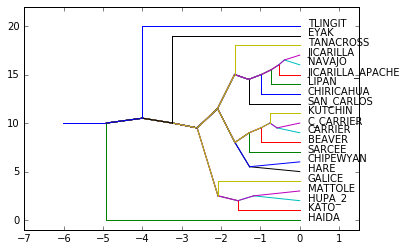

In [7]:
# Just a verification check...to make sure everything is there. 
%matplotlib inline
NaDenePT.showtree()

We will now give estimation of the parameters conditional on tree structure a try just to see if it is working correctly. We will start with the `mwg` version of our MCMC sampler and see how that goes, and see what can be gleaned from it, and then move on to the global sampler. We need to give our sampler an initial variance-covariance matrix, but over time the sampler will adapt this so as to hit the target rate (second to last argument)

In [8]:
VInit=np.eye((np.shape(parmsInit)[1]))
x, y, z = PyIETools.myMcMcSampler_mwg(PyIETools.mlfun, np.matrix(parmsInit), VInit, 100, 10, .5, .28, NaDenePT)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [08:48<00:00,  5.24s/it]


We can now examine some of the results to see how it is going...z denotes acceptances, y denotes values of the objective function, and x is a list of the actual draws. First, we see that the function rises rapidly towards what seems like a steady point, and then flattens out:

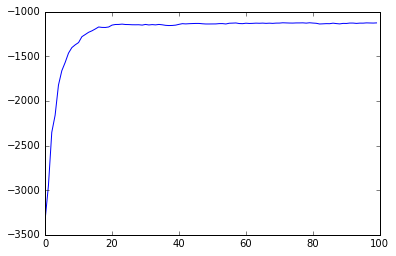

In [11]:
plt.plot(np.array(y).flatten())

What does it look like after this point? It looks like it is jiggling around more or less randomly, which is a good thing, suggesting convergence:

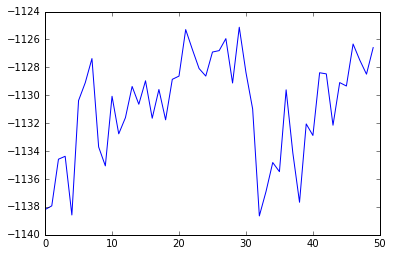

In [12]:
plt.plot(np.array(y).flatten()[50:])

Accordingly, let's now set up a **big global sampler** from this particular tree. We will use the mean and variance of the draws that we have to set this up. It is also useful, however, to have a means of checking whether this matrix is positive definite. I wrote the routine (in `PyIETools`) `is_pos_def` with this in mind. It simply checks to see if all the eigenvalues of the covariance matrix are positive. If it is not, I have written a method - `make_pos_def` that makes the matrix positive definite. All that does is adds a small constant to the diagonal until the positive definiteness test is passed. 

In [13]:
X = np.reshape(x,(100,-1))

In [14]:
xNew=np.matrix(np.average(X[20:], axis=0))
vNew=np.cov(X[20:].T)
print(PyIETools.is_pos_def(vNew))

True


Now, we can run the global sampler...

In [15]:
x, y, z = PyIETools.myMcMcSampler_global(PyIETools.mlfun, xNew, vNew, 10000, 10, .75, .2, NaDenePT)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [15:03<00:00, 11.09it/s]


Let's look at how the overall value of the function varies over time:

In [16]:
Y=np.array(y).flatten()


We see that the values leap up to a stable value and stay around there...Let's make some subplots to telescope in on how this function is behaving:

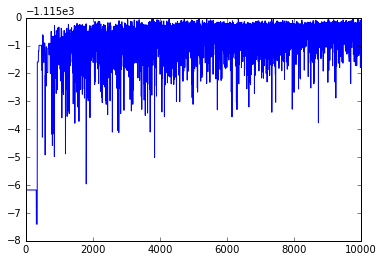

In [17]:
plt.plot(Y)

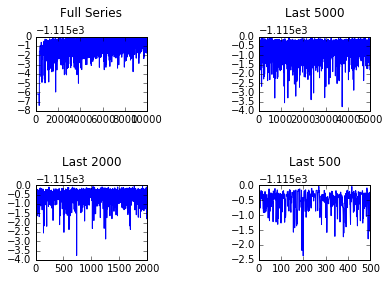

In [18]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
ax1.plot(Y)
ax1.set_title('Full Series', y=1.2)
ax2.plot(Y[5000:])
ax2.set_title('Last 5000', y=1.2)
ax3.plot(Y[8000:])
ax3.set_title('Last 2000', y=1.2)
ax4.plot(Y[9500:])
ax4.set_title('Last 500', y=1.2)
f.subplots_adjust(wspace=1, hspace=1)


Let's also take a look at acceptance rates. These are returned in the container for **`z`**, and we want a running sum. 

In [19]:
movingARate1=[np.sum(z[:N])/len((z[:N])) for N in range(1,10000)]

In [20]:
movingARate2=[np.sum(z[N-100:N])/100 for N in range(101,10000)]

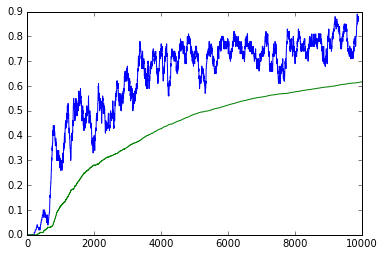

In [21]:
plt.plot(movingARate2)
plt.plot(movingARate1)

So we see how the tuning and acceptance rates are gravitating. I'm somewhat surprised that they are not converging to the specified value of .2, so maybe something is going wrong and should be checked. Let's see what the resulting parameters look like:

In [22]:
xEst=np.reshape(x,(10000,-1))
xEst=np.average(xEst[9000:,:],axis=0)

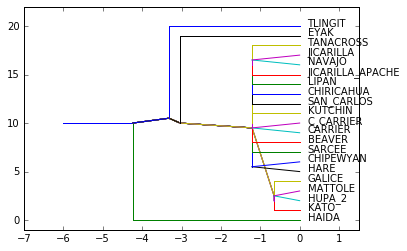

In [23]:
NaDenePT.parameters=np.matrix(xEst)
NaDenePT.unpack()
NaDenePT.showtree()

## (Outer) Estimation Method - Puzzling and MCMC

So now that we have a technique for running MCMC on a given tree, let's talk about how to find a best tree, or how we can introduce this into the algorithm. One thing we might do is start with a puzzling algorithm that mixes the tree around a bit for a fixed set of parameters, or maybe just makes a set of changes to the parameters that involves just one tweak from a set. To this end, we have written a function in `PyIETools` called puzzler, which randomly resolves the tree and checks the value of its likelihood, retaining values that have higher likelihood. The function works more or less as one might expect, and simply requires passing along a phylum name, along with basic data about depth and some parameters.



In [24]:
StartTree=PyIETools.puzzler(Data,Splits,"NADENE","NaDene",100,min[0],max[0],parmsInit)

C:\Users\mjbaker\Documents\GitHub\InstEvo\PyIETools.py:1056: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if parameters=='None':


New Tree Found at  2 :  [[-2935.19171021]]
New Tree Found at  4 :  [[-2813.17758469]]
New Tree Found at  5 :  [[-2402.88543092]]
New Tree Found at  6 :  [[-2302.36221941]]


In [25]:
# Fleshing out a comprehensive estimation method
outer = 100
inner = 10
damper = .9

# Initial values
NaDeneRT=PyIEClasses.ResolvedTree(Data.loc[Data['ruhlen_1']=='NADENE'],'NTree1')
numbranches=NaDeneRT.interiorbranches
bInit=np.matrix(-1-np.linspace(0,10,num=numbranches)/numbranches)
rInit=np.zeros((1,len(NaDeneRT.words)))
dparms=np.sum(NaDeneRT.deathmat[:,0]==0)
dInit=np.zeros((1,dparms))+1
eInit=np.matrix(5)

parmsInit=np.hstack((bInit,rInit,dInit,eInit))
VInit     = np.eye((np.shape(parmsInit)[1]))

Tree = StartTree 
val   = PyIETools.mlfun(parmsInit, Tree) 

DrawnTrees=[]
valRecord =[]
# Will replace currentParms and currentV ultimately
mu = parmsInit
Vu = VInit

for i in range(outer):
    print(i)
    TreeHat=PyIEClasses.ParameterizedTree(Data.loc[Data['ruhlen_1']=='NADENE'],'NTree1',np.matrix(mu))
    TreeHat.priordepth(min[0], max[0])
    TreeHat.splitinfo(Splits[Splits['phylum'] == 'NaDene'])
    TreeHat.settimes()   
    
    parmsHat, vals, junk = PyIETools.myMcMcSampler_mwg(PyIETools.mlfun, np.matrix(mu), 
                                                       Vu, inner, 10, damper, .28, TreeHat)
    
    valHat = vals[-1]
    
    if np.random.uniform(0,1) < np.exp( valHat - val) or i == 0: 
        X = np.reshape(parmsHat, (inner,-1) )
        currentParms = np.copy(X[-1,:])
        val = valHat
        TreeNew = copy.deepcopy(TreeHat)
        TreeNew.parameters = currentParms
        print('new tree!')
    else:
        parmsHat, vals , junk = PyIETools.myMcMcSampler_mwg(PyIETools.mlfun, np.matrix(mu), 
                                                            Vu, inner, 10, damper, .28, TreeNew)
        X = np.reshape(parmsHat, (inner,-1) )
        currentParms = np.copy(X[-1,:])
        TreeNew = copy.deepcopy(Tree)
        TreeNew.parameters = currentParms 
        val = vals[-1]
    
    valRecord.append(val)
    print('Current log-likelihood: ', val)
    DrawnTrees.append(TreeNew)
    
    # Update proposal distribution 
    it = i + 1
    mu = mu + (1/(it + 1))**damper*(currentParms - mu)
    Vu = Vu + (1/(it + 1))**damper*((currentParms - mu).T*(currentParms - mu) - Vu)
    Vu = np.eye(np.shape(Vu)[0])*np.diagonal(Vu)

    TreeNew.priordepth(min[0], max[0])
    TreeNew.splitinfo(Splits[Splits['phylum'] == 'NaDene'])
    TreeNew.settimes()  
    
    if PyIETools.is_pos_def(Vu)==False:
        Vu = PyIETools.make_pos_def(Vu)
        break

0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.61s/it]


new tree!
Current log-likelihood:  [[-1530.6227749]]
1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.60s/it]


new tree!
Current log-likelihood:  [[-1426.80322045]]
2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.27s/it]


new tree!
Current log-likelihood:  [[-1310.09259236]]
3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.29s/it]


new tree!
Current log-likelihood:  [[-1308.88803409]]
4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.22s/it]


new tree!
Current log-likelihood:  [[-1219.570811]]
5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.47s/it]


Current log-likelihood:  [[-1182.62229522]]
6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  7.22s/it]


Current log-likelihood:  [[-1186.70342587]]
7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.89s/it]


Current log-likelihood:  [[-1177.17121443]]
8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.55s/it]


Current log-likelihood:  [[-1179.99524974]]
9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.55s/it]


Current log-likelihood:  [[-1176.66712637]]
10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.84s/it]


Current log-likelihood:  [[-1168.771985]]
11


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.35s/it]


Current log-likelihood:  [[-1158.79416193]]
12


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.55s/it]


Current log-likelihood:  [[-1177.16482911]]
13


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.28s/it]


Current log-likelihood:  [[-1176.04078158]]
14


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  6.22s/it]


new tree!
Current log-likelihood:  [[-1161.73670674]]
15


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.46s/it]


Current log-likelihood:  [[-1161.24321762]]
16


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.40s/it]


Current log-likelihood:  [[-1172.76130939]]
17


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.34s/it]


new tree!
Current log-likelihood:  [[-1172.80771902]]
18


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.38s/it]


Current log-likelihood:  [[-1176.71778066]]
19


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:54<00:00,  5.43s/it]


Current log-likelihood:  [[-1175.95477994]]
20


 60%|████████████████████████████████████████████████████████████████████████                                                | 6/10 [00:36<00:24,  6.18s/it]

KeyboardInterrupt: 

In [ ]:
pd.to_pickle(DrawnTrees,'IEData\\NaDeneDraws.pkl')